<a href="https://colab.research.google.com/github/stefanogiagu/corso_AML_2022/blob/main/notebooks/es10/AML_2022_HandsOn_10_Normalizing_flow_realNVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#run this if first time!
!pip install --upgrade git+https://github.com/VincentStimper/normalizing-flows.git
#!git clone https://github.com/VincentStimper/normalizing-flows.git
#!pip install -r normalizing-flows/requirements_examples.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/VincentStimper/normalizing-flows.git to /tmp/pip-req-build-60_hxa62
  Running command git clone -q https://github.com/VincentStimper/normalizing-flows.git /tmp/pip-req-build-60_hxa62
  Cloning https://github.com/VincentStimper/residual-flows.git to /tmp/pip-install-7akhroja/residual-flows_04d307d77f1645848780bf87f7f4c2d8
  Running command git clone -q https://github.com/VincentStimper/residual-flows.git /tmp/pip-install-7akhroja/residual-flows_04d307d77f1645848780bf87f7f4c2d8
  Created wheel for normflow: filename=normflow-1.2-py2.py3-none-any.whl size=60862 sha256=16b19f76ef178ef82521cdee35166a756f0a70808db411fcc741760b4aad2fa0
  Stored in directory: /tmp/pip-ephem-wheel-cache-mzxtnjz4/wheels/d9/40/c8/9ac98610e01d078086ad1abd95cd552ce5eef5bec50c647dd5
  Created wheel for residual-flows: filename=residual_flows-1.0-py2.py3-none-any.whl size=36203 sha256=cbde5c

In [2]:
# Import required packages
import torch
from torch import nn
import numpy as np
import normflow as nf

from matplotlib import pyplot as plt
from tqdm import tqdm

# A "related" example : Generating exponential distributed numbers with an uniform generator

Lets say that we want to generate number with an exponential distribution. The pdf is

$$ f(x) = \begin{Bmatrix}
 \lambda e^{-\lambda x},& x>=0  \\
 0,&   x<0\\
\end{Bmatrix} $$

And the cdf is

$$F(x) = \int_{-\inf}^{x} f(t)dt =  \begin{Bmatrix}
 1- \lambda e^{-\lambda x},& x>=0  \\
 0,&   x<0\\
\end{Bmatrix}$$

If we can generate numbers with a uniform distribution (calling rand for example) we can then:
- Compute the cdf of the desired random variable
- Set $R = F(X)$ on the range of $X$ (For the exponential distribution, $ R = 1 - e^{-\lambda x} $ on the range of $x \ge 0$. )
- Solve the equation F(X) = R for $X$ in terms of $R$. 

For the exponential distribution above we have

$$ X = \frac{-1}{\lambda} \ln(1-R)$$

We can try in a few lines of code below.

This is an easy case  but once we have this procedure established, we can proceed to solve other similar distribution for which a inverse function is relatively easy to obtain and has a closed formula. 

**Unfurtunately, the vast majority of interesting distributions can not be inverted**

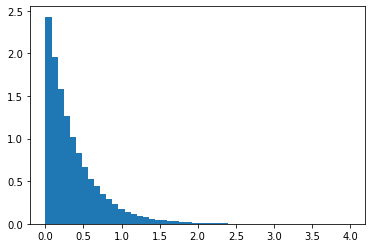

In [3]:
# We can try in a few lines of code
def ExpPowerFun(l, size=1000):
    x = np.random.rand(size)
    return np.log(1-x)*(-1.0/l)

import matplotlib.pyplot as plt
plt.hist(ExpPowerFun(2.7,100000),50,density=True)
plt.show()


# First ingredient - the Flow

- We need to define a set of invertible (bijective) function that we will combine to obtain a complex (but still invertible) function. This set of function will be called "the flow"
- A item of the flow has a direct call and an algebraic iverse call

[direct inverse](https://drive.google.com/uc?id=1CDwhHNrfaKBoBvhinGDIWm-b4oNj_TNg)

In [4]:
class Flow(nn.Module):
    """
    Generic class for flow functions
    """
    def __init__(self):
        super().__init__()

    def forward(self, z):
        """
        :param z: input variable, first dimension is batch dim
        :return: transformed z and log of absolute determinant
        """
        raise NotImplementedError('Forward pass has not been implemented.')

    def inverse(self, z):
        raise NotImplementedError('This flow has no algebraic inverse.')

In [5]:
class MaskedAffineFlow(Flow):
    """
    RealNVP as introduced in arXiv: 1605.08803
    Masked affine flow f(z) = b * z + (1 - b) * (z * exp(s(b * z)) + t)
    class AffineHalfFlow(Flow): is MaskedAffineFlow with alternating bit mask
    NICE is AffineFlow with only shifts (volume preserving)
    """

    def __init__(self, b, t, s):
        """
        Constructor
        :param b: mask for features, i.e. tensor of same size as latent data point filled with 0s and 1s
        :param t: translation mapping, i.e. neural network, where first input dimension is batch dim,
        if None no translation is applied
        :param s: scale mapping, i.e. neural network, where first input dimension is batch dim,
        if None no scale is applied
        """
        super().__init__()
        self.b_cpu = b.view(1, *b.size())
        self.register_buffer('b', self.b_cpu)

        self.add_module('s', s)

        self.add_module('t', t)

    def forward(self, z):
        z_masked = self.b * z
        scale = self.s(z_masked)
        nan = torch.tensor(np.nan, dtype=z.dtype, device=z.device)
        scale = torch.where(torch.isfinite(scale), scale, nan)
        trans = self.t(z_masked)
        trans = torch.where(torch.isfinite(trans), trans, nan)
        z_ = z_masked + (1 - self.b) * (z * torch.exp(scale) + trans) # direct transform
        log_det = torch.sum((1 - self.b) * scale, dim=list(range(1, self.b.dim()))) # since this term is exp(s) the log is just the scale function
        return z_, log_det

    def inverse(self, z):# analitical inverse
        z_masked = self.b * z
        scale = self.s(z_masked)
        nan = torch.tensor(np.nan, dtype=z.dtype, device=z.device)
        scale = torch.where(torch.isfinite(scale), scale, nan)
        trans = self.t(z_masked)
        trans = torch.where(torch.isfinite(trans), trans, nan)
        z_ = z_masked + (1 - self.b) * (z - trans) * torch.exp(-scale)
        log_det = -torch.sum((1 - self.b) * scale, dim=list(range(1, self.b.dim())))
        return z_, log_det

In [6]:
class ActNorm(Flow):
    """
    scales and shifts with learned constants per dimension. 
    """

    def __init__(self, shape):
        """
        Constructor
        :param shape: Shape of the coupling layer
  
        """
        super().__init__()
        
        self.s = nn.Parameter(torch.zeros(shape)[None]) # this is the shift function
        
        
        self.t = nn.Parameter(torch.zeros(shape)[None]) # this is the scale function
        
        self.n_dim = self.s.dim()
        self.batch_dims = torch.nonzero(torch.tensor(self.s.shape) == 1, as_tuple=False)[:, 0].tolist()
        self.data_dep_init_done_cpu = torch.tensor(0.)
        self.register_buffer('data_dep_init_done', self.data_dep_init_done_cpu)

    def forward(self, z):
        
         # first batch is used for initialization, c.f. batchnorm
        if not self.data_dep_init_done > 0.:
            assert self.s is not None and self.t is not None
            s_init = -torch.log(z.std(dim=self.batch_dims, keepdim=True) + 1e-6)
            self.s.data = s_init.data
            self.t.data = (-z.mean(dim=self.batch_dims, keepdim=True) * torch.exp(self.s)).data
            self.data_dep_init_done = torch.tensor(1.)
        
        z_ = z * torch.exp(self.s) + self.t
        if len(self.batch_dims) > 1:
            prod_batch_dims = np.prod([z.size(i) for i in self.batch_dims[1:]])
        else:
            prod_batch_dims = 1
        log_det = prod_batch_dims * torch.sum(self.s)
        return z_, log_det

    def inverse(self, z):
        
         # first batch is used for initialization, c.f. batchnorm
        if not self.data_dep_init_done:
            assert self.s is not None and self.t is not None
            s_init = torch.log(z.std(dim=self.batch_dims, keepdim=True) + 1e-6)
            self.s.data = s_init.data
            self.t.data = z.mean(dim=self.batch_dims, keepdim=True).data
            self.data_dep_init_done = torch.tensor(1.)
        
        
        z_ = (z - self.t) * torch.exp(-self.s)
        if len(self.batch_dims) > 1:
            prod_batch_dims = np.prod([z.size(i) for i in self.batch_dims[1:]])
        else:
            prod_batch_dims = 1
        log_det = -prod_batch_dims * torch.sum(self.s)
        return z_, log_det


In [7]:
class MLP(nn.Module):
    """
    A multilayer perceptron with Leaky ReLU nonlinearities
    """

    def __init__(self, layers, leaky=0.0, output_fn=None, init_zeros=False, dropout=None):
       
        super().__init__()
        net = nn.ModuleList([])
        for k in range(len(layers)-2):
            net.append(nn.Linear(layers[k], layers[k+1]))
            net.append(nn.LeakyReLU(leaky))
        if dropout is not None:
            net.append(nn.Dropout(p=dropout))
        net.append(nn.Linear(layers[-2], layers[-1]))
        if init_zeros:
            nn.init.zeros_(net[-1].weight)
            nn.init.zeros_(net[-1].bias)
        if output_fn is not None:
           
            if output_fn == "sigmoid":
                net.append(nn.Sigmoid())
            elif output_fn == "relu":
                net.append(nn.ReLU())
            elif output_fn == "tanh":
                net.append(nn.Tanh())
            else:
                NotImplementedError("This output function is not implemented.")
        self.net = nn.Sequential(*net)

    def forward(self, x):
        return self.net(x)

In [8]:
# Set up model

# Define flows
K = 32 # number of transformation if the flow
torch.manual_seed(0)

latent_size = 2
b = torch.Tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])
flows = []# here we will put the "flow" of simple invertible transformation
for i in range(K):
    s = MLP([latent_size, 2 * latent_size, latent_size], init_zeros=True)# this is just a 3 layer MLP. Only input and output must be equal to the latent size. Hidden layer can be of any size
    t = MLP([latent_size, 2 * latent_size, latent_size], init_zeros=True)
    if i % 2 == 0:
        flows += [MaskedAffineFlow(b, t, s)]
    else:
        flows += [MaskedAffineFlow(1 - b, t, s)]
    flows += [ActNorm(latent_size)]

# Set prior and q0
prior = nf.distributions.TwoModes(2, 0.1)
q0 = nf.distributions.DiagGaussian(2)

In [9]:
def set_requires_grad(module, flag):
    """
    Sets requires_grad flag of all parameters of a torch.nn.module
    :param module: torch.nn.module
    :param flag: Flag to set requires_grad to
    """

    for param in module.parameters():
        param.requires_grad = flag


class NormalizingFlow(nn.Module):
    """
    Normalizing Flow model to approximate target distribution
    """
    def __init__(self, q0, flows, p=None):
        """
        Constructor
        :param q0: Base distribution
        :param flows: List of flows
        :param p: Target distribution
        """
        super().__init__()
        self.q0 = q0
        self.flows = nn.ModuleList(flows)
        self.p = p


    def reverse_kld(self, num_samples=1, beta=1.):
        """
        Estimates reverse KL divergence, see arXiv 1912.02762
        :param num_samples: Number of samples to draw from base distribution
        :param beta: Annealing parameter, see arXiv 1505.05770
        :return: Estimate of the reverse KL divergence averaged over latent samples
        """
        z, log_q = self.q0(num_samples)
        for flow in self.flows:
            z, log_det = flow(z) # chain of transformation
            log_q -= log_det
        
        log_p = self.p.log_prob(z) # z match the prior?
        return torch.mean(log_q) - beta * torch.mean(log_p)


    def sample(self, num_samples=1):
        """
        Samples from flow-based approximate distribution
        :param num_samples: Number of samples to draw
        :return: Samples, log probability
        """
        z, log_q = self.q0(num_samples)
        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det
        return z, log_q

    def log_prob(self, x):
        """
        Get log probability for batch
        :param x: Batch
        :return: log probability
        """
        log_q = torch.zeros(len(x), dtype=x.dtype, device=x.device)
        z = x
        for i in range(len(self.flows) - 1, -1, -1):
            z, log_det = self.flows[i].inverse(z)
            log_q += log_det
        log_q += self.q0.log_prob(z)
        return log_q

    def save(self, path):
        """
        Save state dict of model
        :param path: Path including filename where to save model
        """
        torch.save(self.state_dict(), path)

    def load(self, path):
        """
        Load model from state dict
        :param path: Path including filename where to load model from
        """
        self.load_state_dict(torch.load(path))

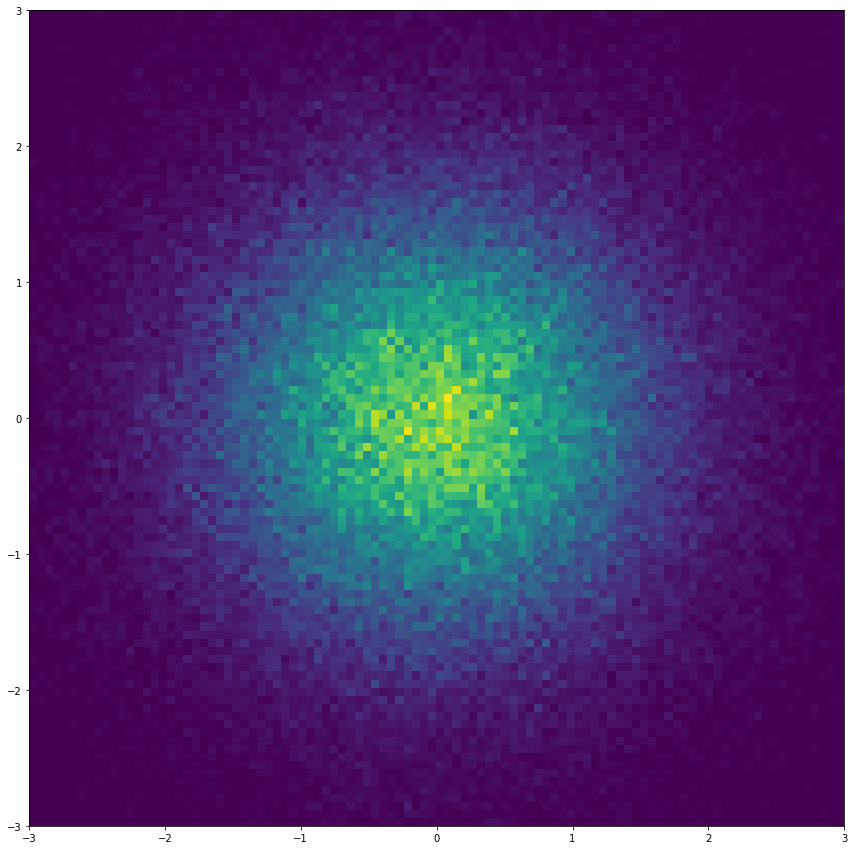

In [10]:
# Construct flow model
nfm = NormalizingFlow(q0=q0, flows=flows, p=prior)

# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
nfm = nfm.to(device)
nfm = nfm.double()

# Initialize ActNorm
z, _ = nfm.sample(num_samples=2 ** 17)
z_np = z.to('cpu').data.numpy()
plt.figure(figsize=(15, 15))
plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (100, 100), range=[[-3, 3], [-3, 3]])
plt.gca().set_aspect('equal', 'box')
plt.show()

In [11]:
# Plot prior distribution
grid_size = 200
xx, yy = torch.meshgrid(torch.linspace(-3, 3, grid_size), torch.linspace(-3, 3, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.double().to(device)
log_prob = prior.log_prob(zz).to('cpu').view(*xx.shape)
prob_prior = torch.exp(log_prob)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


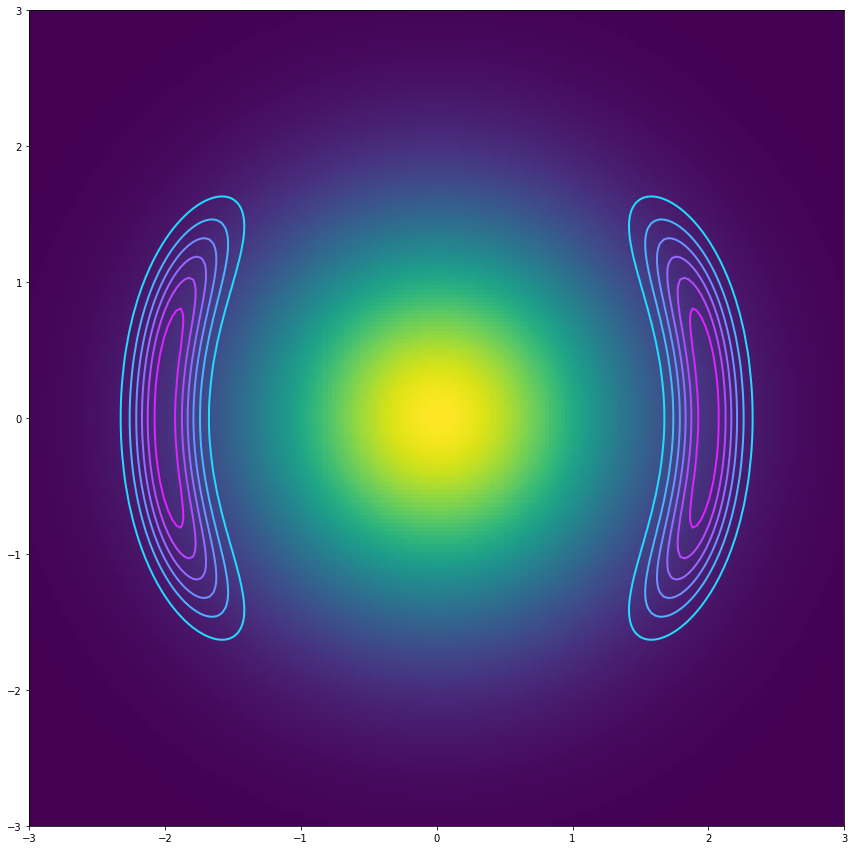

In [12]:
# Plot initial posterior distribution
log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.contour(xx, yy, prob_prior.data.numpy(), cmap=plt.get_cmap('cool'), linewidths=2)
plt.gca().set_aspect('equal', 'box')
plt.show()

  7%|▋         | 1999/30000 [01:27<18:05, 25.79it/s]

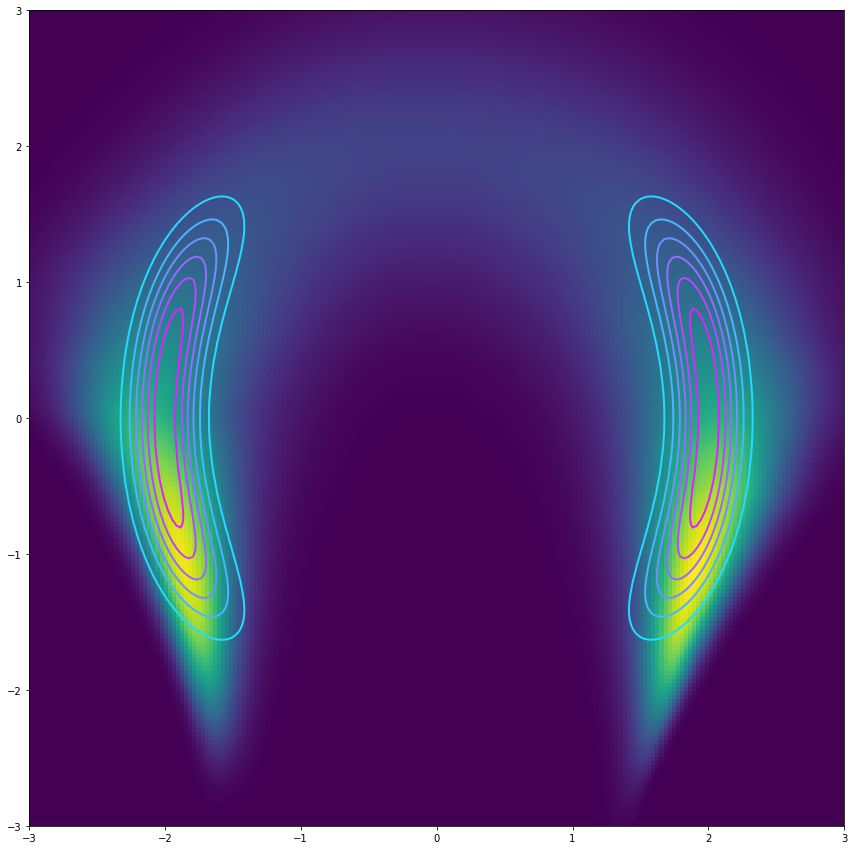

 13%|█▎        | 3997/30000 [02:50<16:59, 25.50it/s]

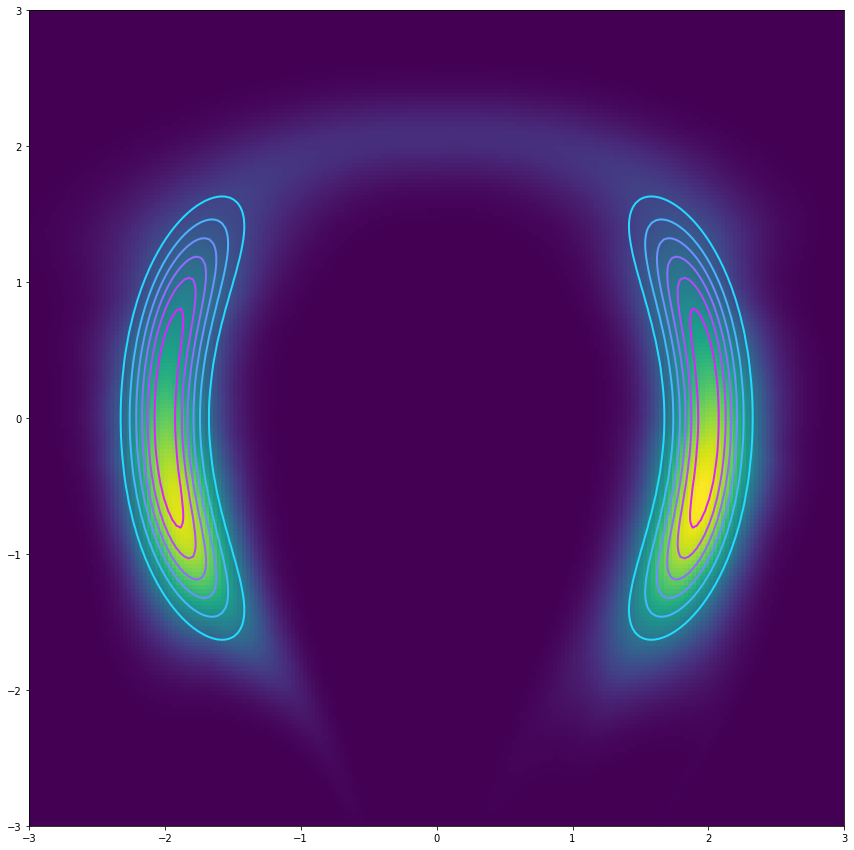

 20%|█▉        | 5998/30000 [04:11<16:30, 24.22it/s]

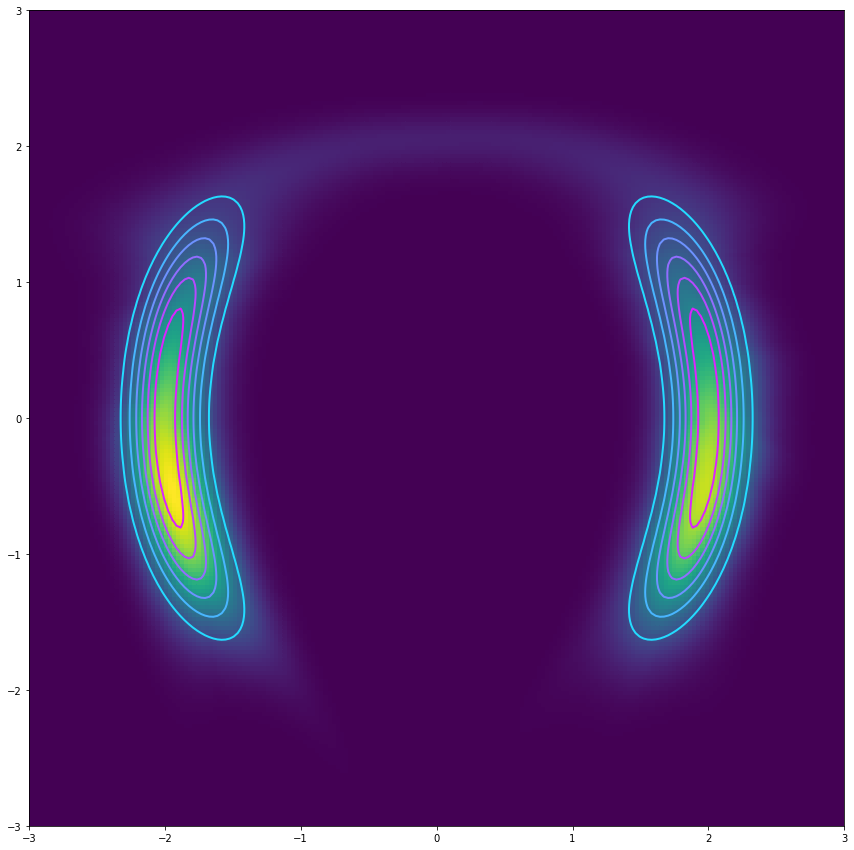

 27%|██▋       | 7999/30000 [05:34<15:00, 24.44it/s]

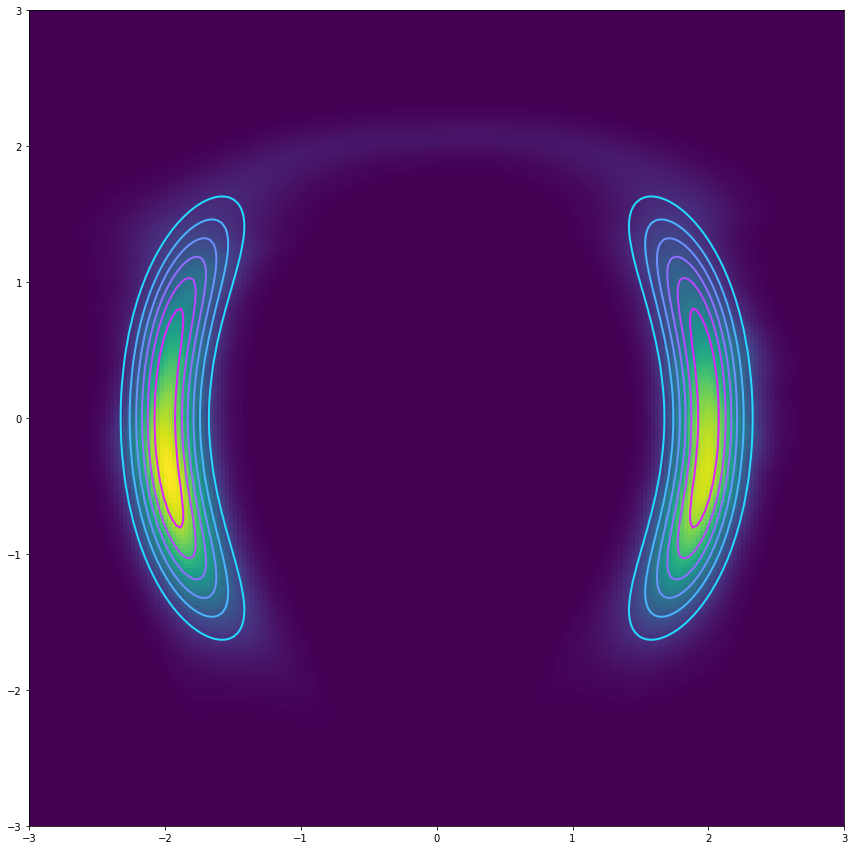

 33%|███▎      | 9997/30000 [06:57<13:42, 24.32it/s]

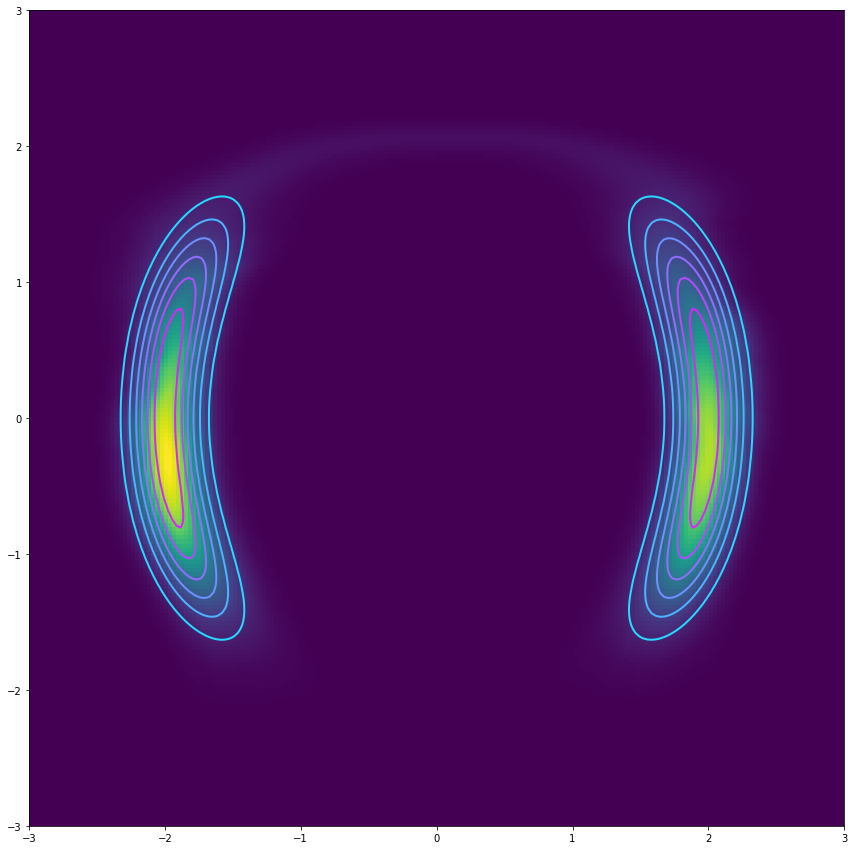

 40%|███▉      | 11997/30000 [08:35<13:01, 23.05it/s]

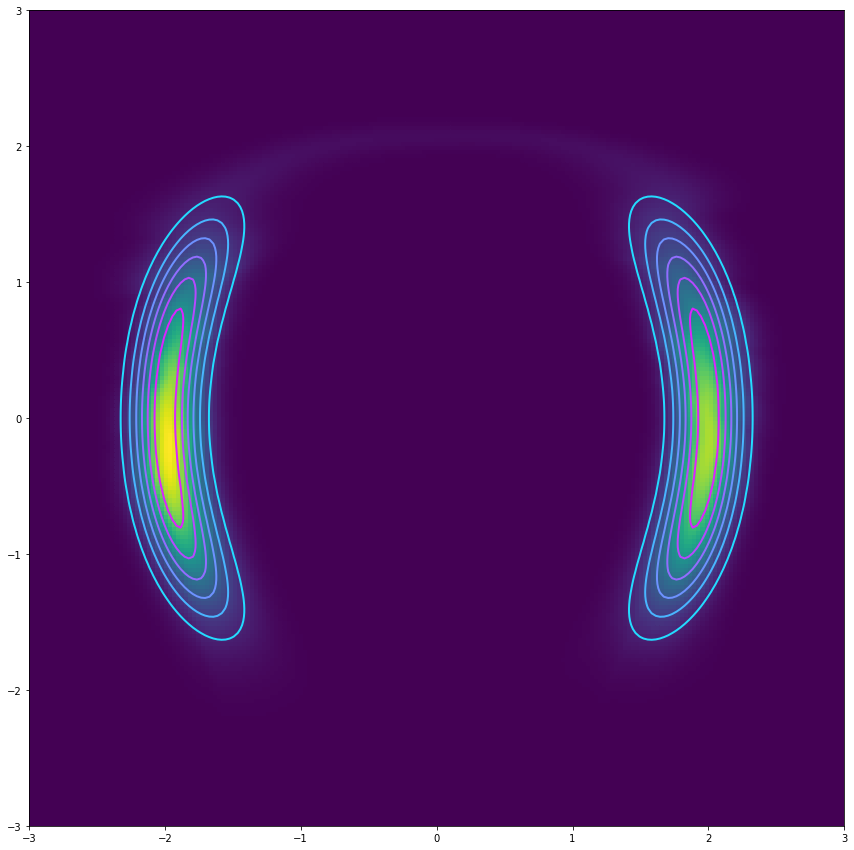

 47%|████▋     | 13997/30000 [10:00<10:55, 24.43it/s]

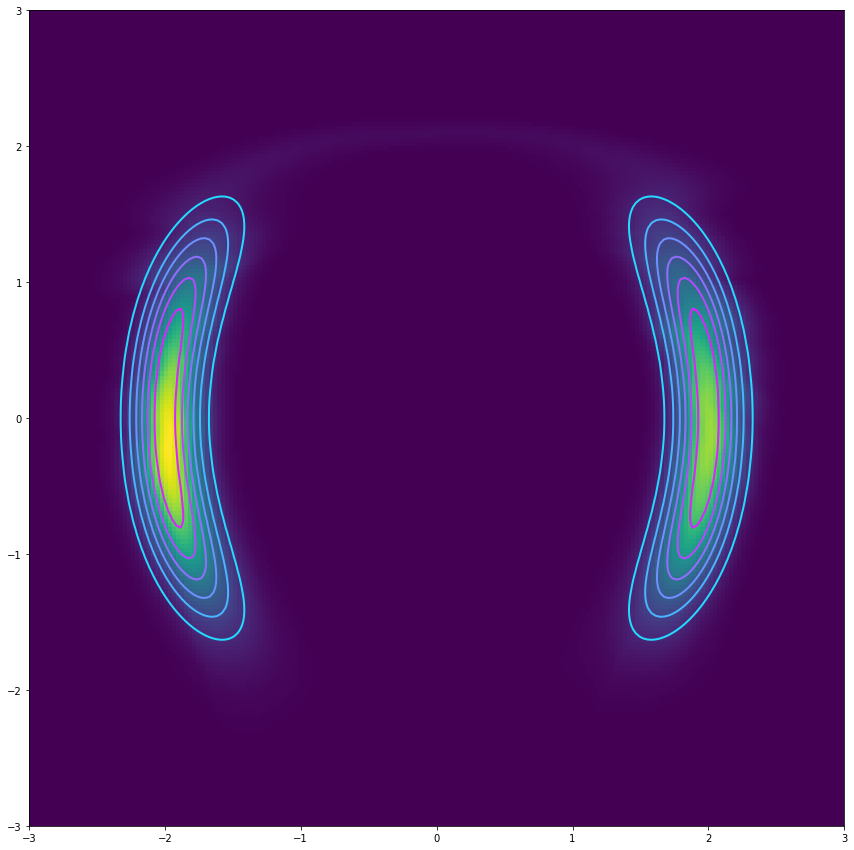

 53%|█████▎    | 15997/30000 [11:26<09:53, 23.61it/s]

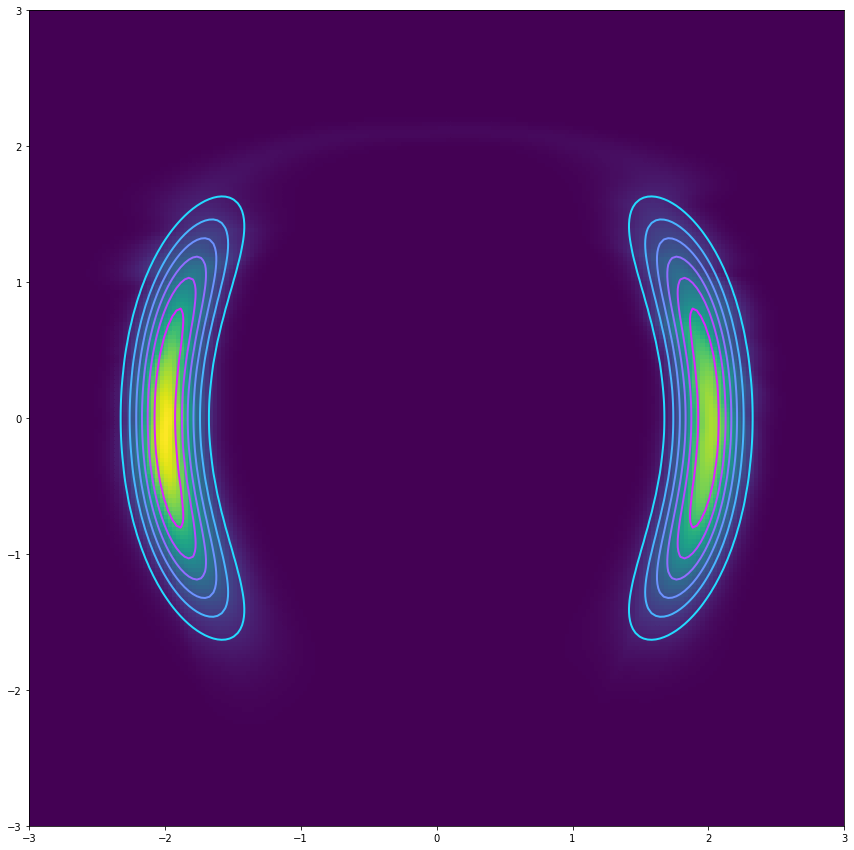

 60%|█████▉    | 17997/30000 [12:51<08:34, 23.31it/s]

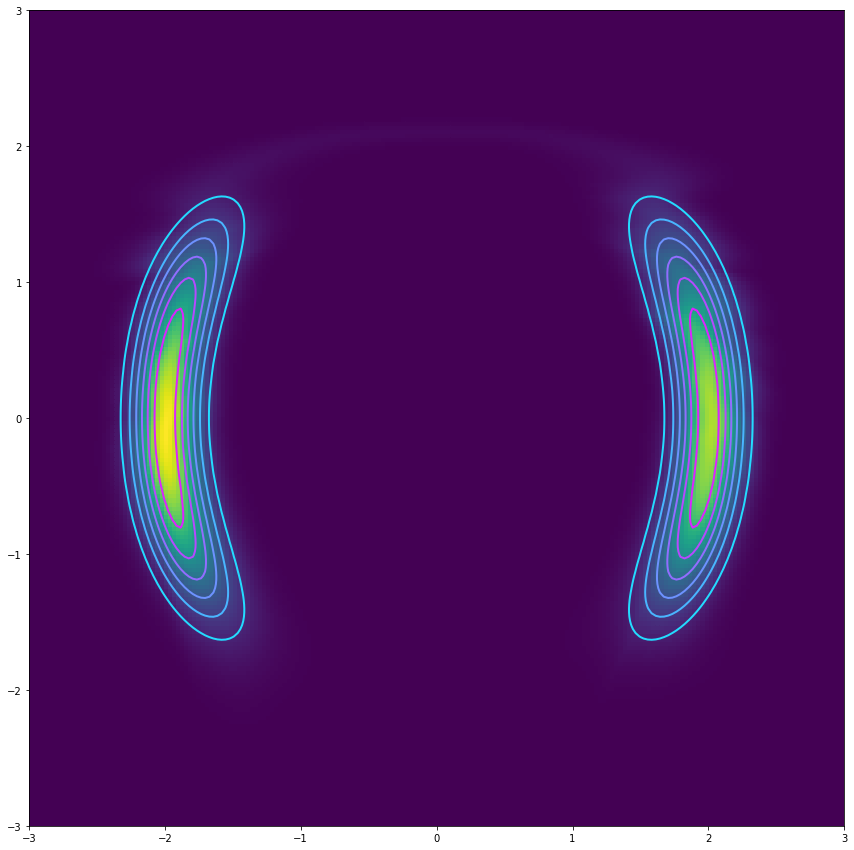

 67%|██████▋   | 19999/30000 [14:17<06:59, 23.85it/s]

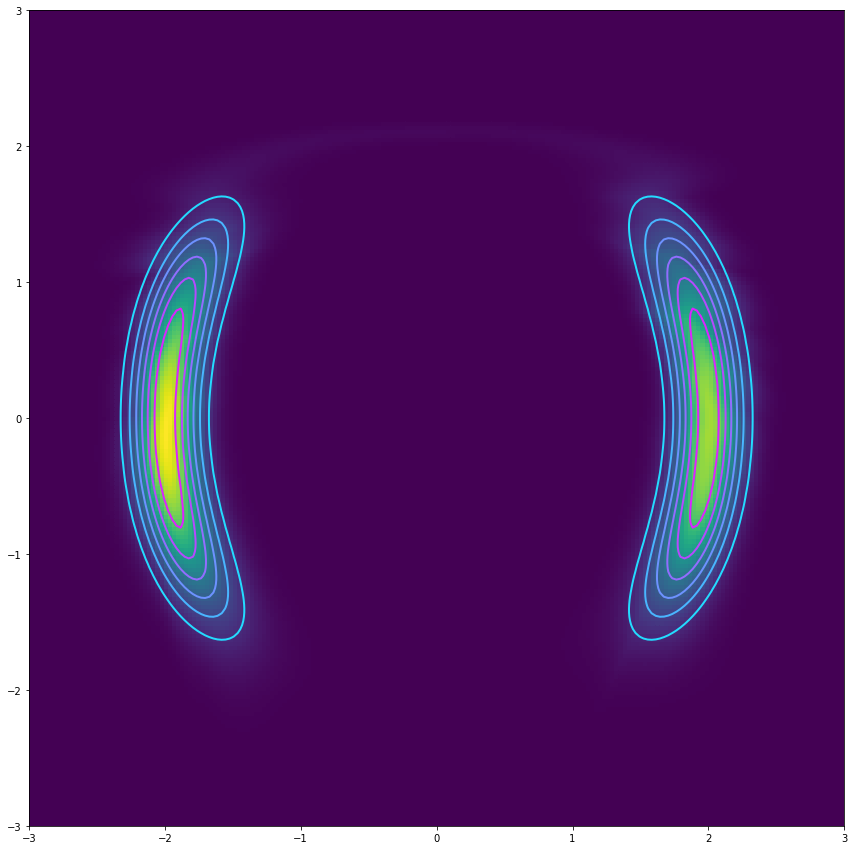

 73%|███████▎  | 21997/30000 [15:43<05:36, 23.79it/s]

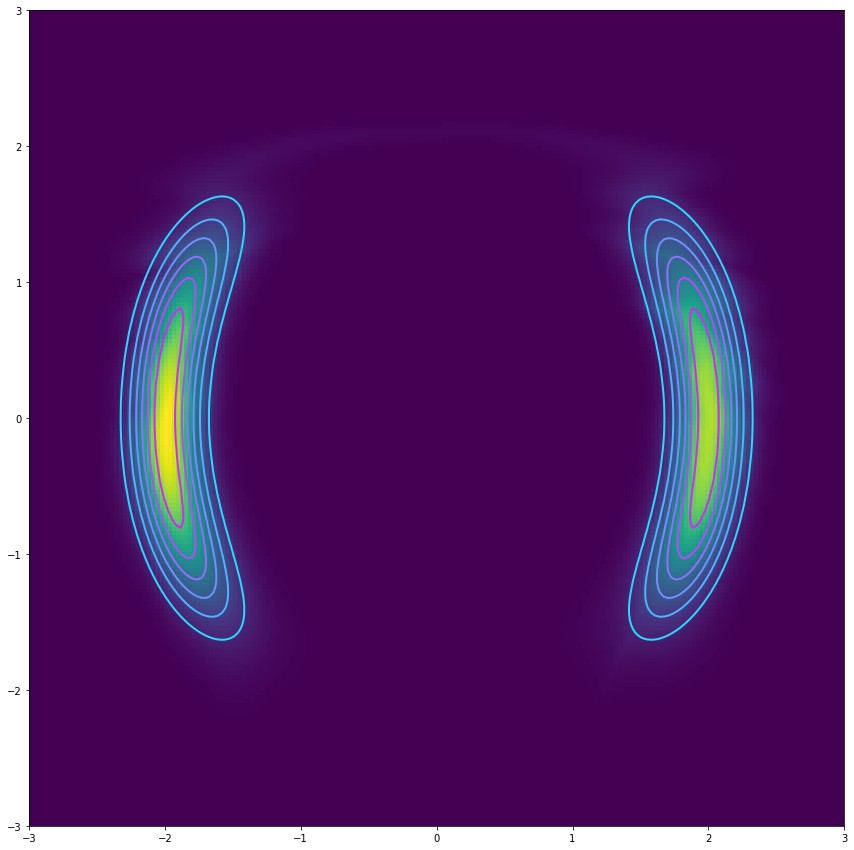

 80%|███████▉  | 23997/30000 [17:09<04:09, 24.06it/s]

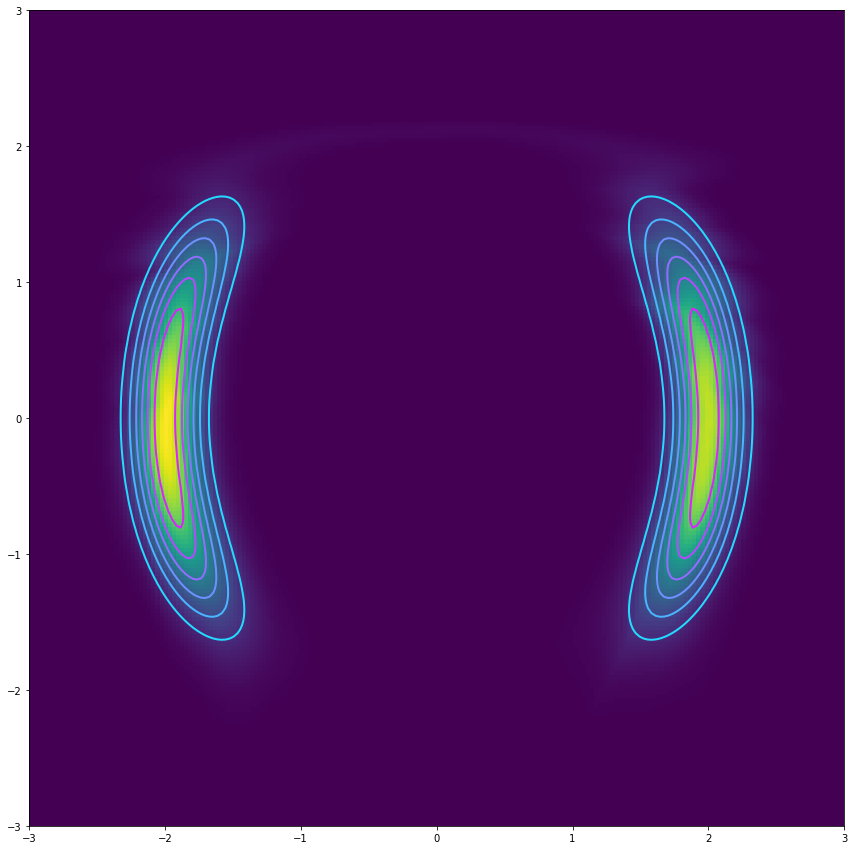

 87%|████████▋ | 25997/30000 [18:36<02:53, 23.03it/s]

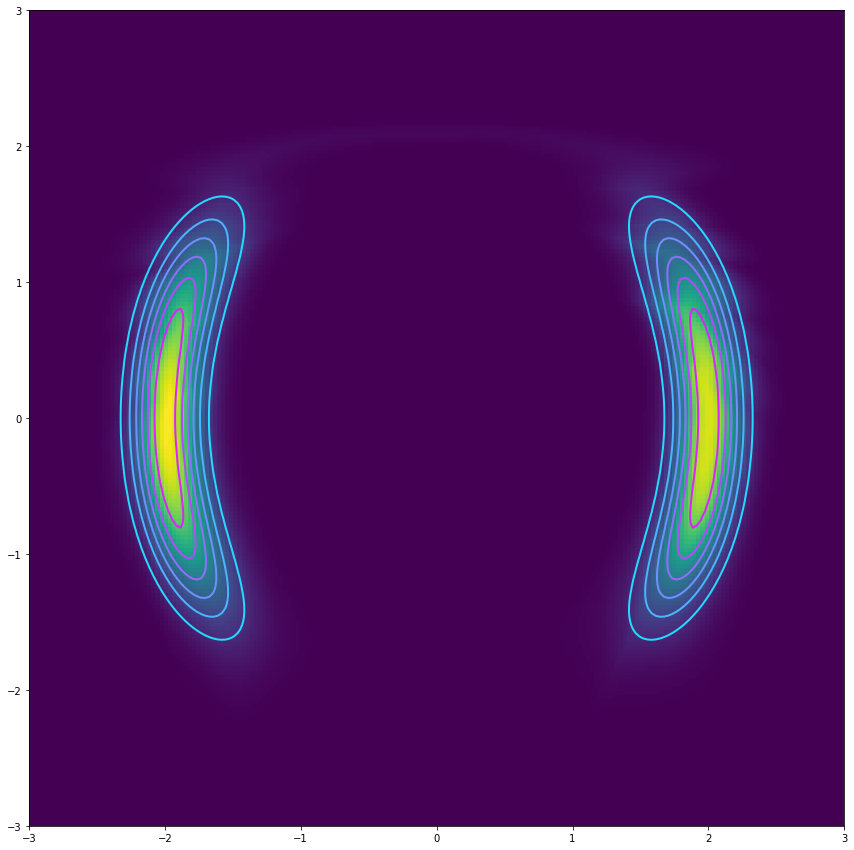

 93%|█████████▎| 27997/30000 [20:03<01:24, 23.67it/s]

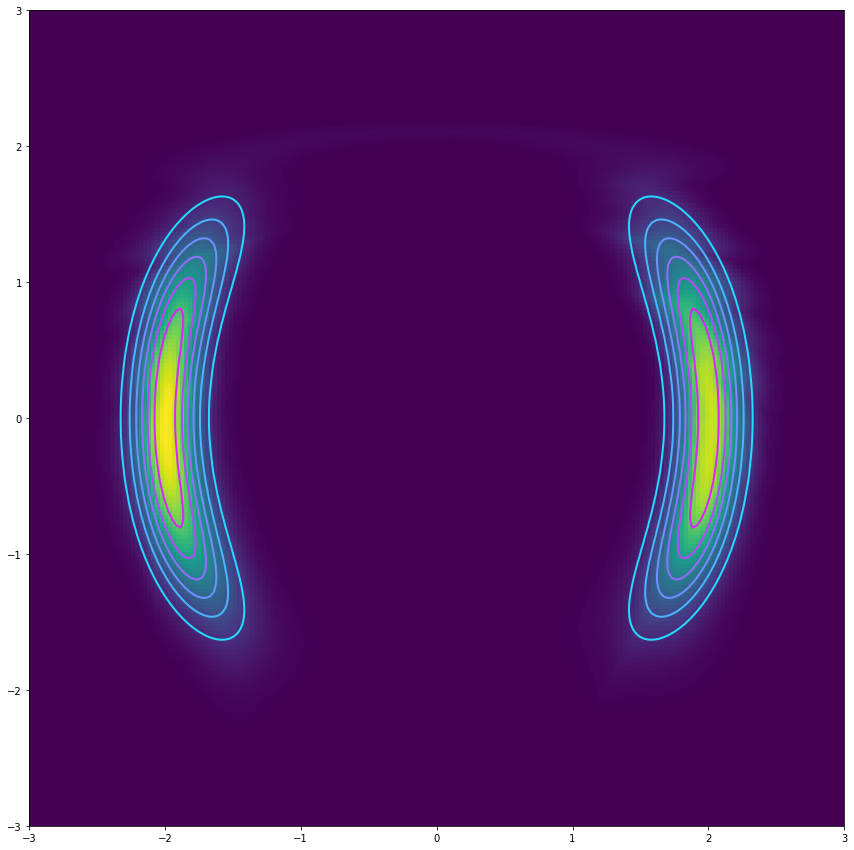

100%|█████████▉| 29997/30000 [21:30<00:00, 23.55it/s]

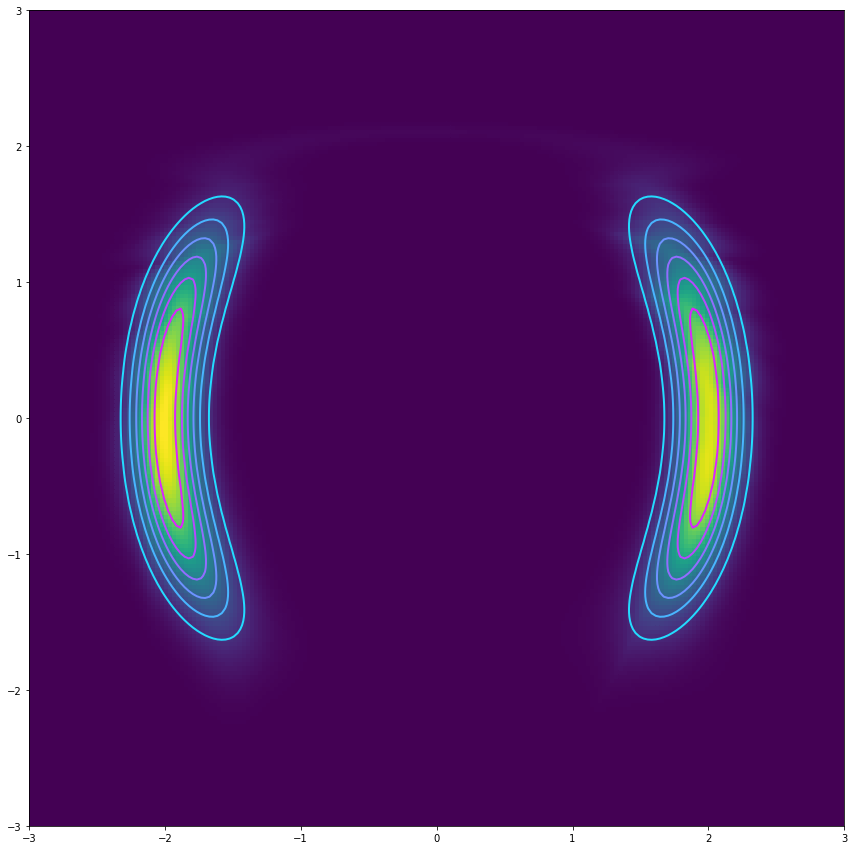

100%|██████████| 30000/30000 [21:31<00:00, 23.23it/s]


In [13]:
# Train model
max_iter = 30000
num_samples = 2 * 100
anneal_iter = 10000

show_iter = 2000


loss_hist = np.array([])

optimizer = torch.optim.Adam(nfm.parameters(), lr=5e-4, weight_decay=1e-6)
for it in tqdm(range(max_iter)):# tqdm is the progress bar
    optimizer.zero_grad()
    
    loss = nfm.reverse_kld(num_samples, beta=np.min([1., 0.001 + it / anneal_iter]))
   
    
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()
    
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    
    # Plot learned posterior
    if ((it + 1) % show_iter) | (it == 500) == 0:
        log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape)
        prob = torch.exp(log_prob)
        prob[torch.isnan(prob)] = 0

        plt.figure(figsize=(15, 15))
        plt.pcolormesh(xx, yy, prob.data.numpy())
        plt.contour(xx, yy, prob_prior.data.numpy(), cmap=plt.get_cmap('cool'), linewidths=2)
        plt.gca().set_aspect('equal', 'box')
        plt.show()

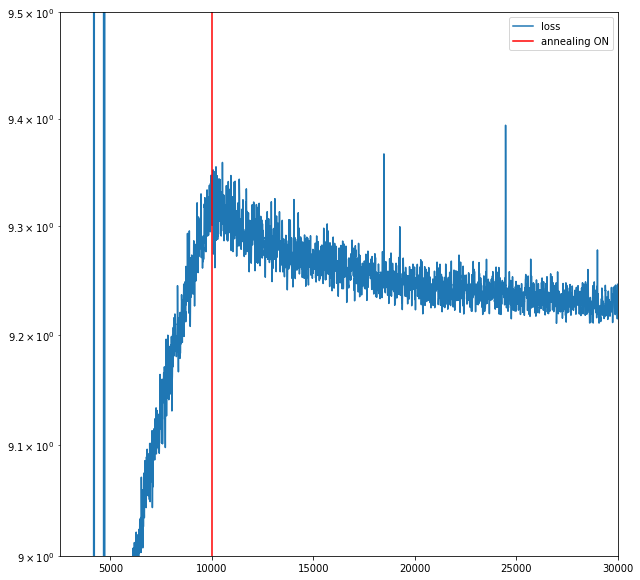

In [17]:
from scipy.ndimage.filters import gaussian_filter1d

loss_hist = gaussian_filter1d(loss_hist, sigma=3)

plt.figure(figsize=(10, 10))
plt.plot(loss_hist+10, label='loss')

plt.xlim([2500,max_iter])
plt.yscale('log')
plt.ylim(9,9.5)
plt.axvline(10000,label="annealing ON",color="r")
plt.legend()
plt.show()


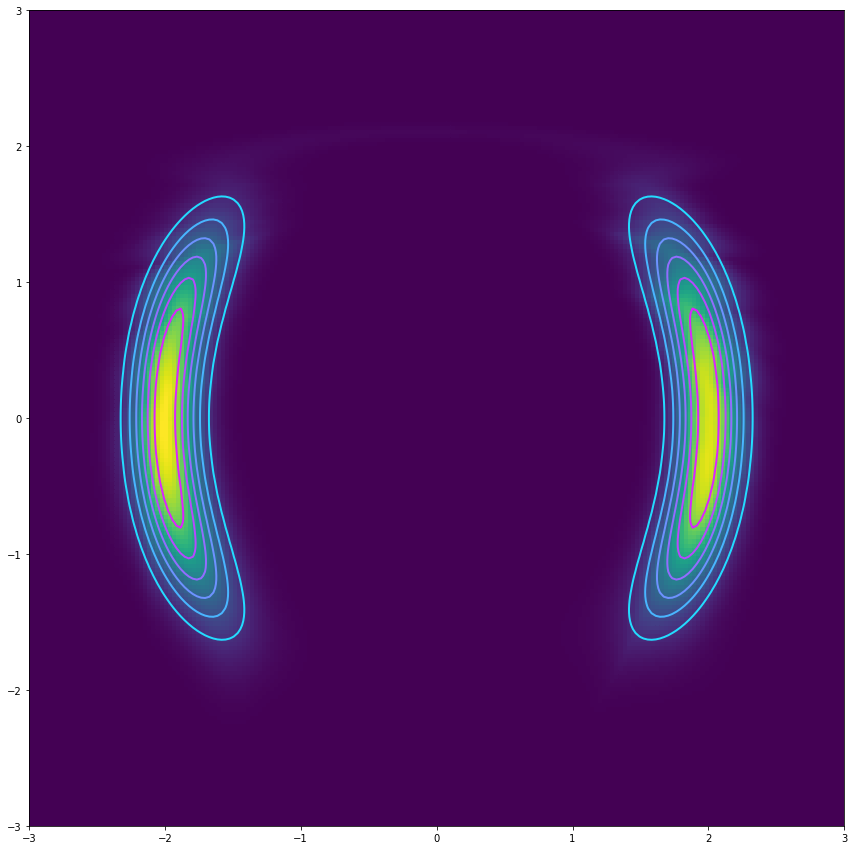

In [15]:
# Plot learned posterior distribution
log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.contour(xx, yy, prob_prior.data.numpy(), cmap=plt.get_cmap('cool'), linewidths=2)
plt.gca().set_aspect('equal', 'box')
plt.show()